In [287]:
import time

def exec_time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} 실행 시간: {end_time - start_time:.5f}초")
        return result
    return wrapper

In [288]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Literal
import math
from filterpy.monte_carlo import multinomial_resample
from filterpy.monte_carlo import residual_resample
from filterpy.monte_carlo import stratified_resample
from filterpy.monte_carlo import systematic_resample
from dtaidistance import dtw


UnitType = Literal['meter', 'coordinate']

class ParticleFilter:
    def __init__(self, m_map, gaussian_params, num_particles: int, map_constraints: np.ndarray, step_noise=0.2, gyro_noise=0.1, map_noise=0.2, plot=False, unit: UnitType = 'coordinate'):
        """
        Initialize the particle filter.
        :param gaussian_params: Dict with Gaussian parameters {'mean_x', 'mean_y', 'std_x', 'std_y'}
        :param num_particles: Number of particles.
        :param map_constraints: Spatial constraints of the map (e.g., walls, paths).
        :param gyro_noise: Standard deviation of noise added to direction changes.
        :param map_noise: Standard deviation of noise in map matching.
        """
        m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])
        self.m_map = {(row.X, row.Y): row.mag for row in m_map_df.itertuples()}
        self.gaussian_params = gaussian_params  
        self.num_particles = num_particles
        self.map_constraints = map_constraints
        self.gyro_noise = gyro_noise
        self.step_noise = step_noise
        self.map_noise = map_noise
        self.plot = plot
        self.unit = unit
        
        self.particles = self.initialize_particles()


    @exec_time_decorator
    def initialize_particles(self):
        """
        Randomly initialize particles based on map constraints.
        """
        particles = []

        for _ in range(self.num_particles):
            while True:
                # Generate x and y from Gaussian distribution
                x = np.random.normal(self.gaussian_params['mean_x'], self.gaussian_params['std_x'])
                y = np.random.normal(self.gaussian_params['mean_y'], self.gaussian_params['std_y'])
                
                # Check if the generated coordinates are within the map constraints
                if self.map_constraints_check(x, y):
                    # print(f"({x},{y} is in map")
                    break

            # Random direction for the particle
            # direction = np.arctan2(x - self.gaussian_params['mean_x'], y - self.gaussian_params['mean_y'])  # Direction in radians
            direction = math.radians(110)
            particles.append({'x': x, 'y': y, 'direction': direction, 'weight': 1.0})

            # Initialize the particle with weight 1.0
            # particles = pd.concat([particles, new_particle], ignore_index=True)

        return pd.DataFrame(particles, columns=['x', 'y', 'direction', 'weight'])


    @exec_time_decorator
    def move_particles(self, step_length: float, step_radian: float):
        """
        Move particles based on step length and gyro data.
        """
        if self.unit == 'coordinate':
            step_length /= 0.6

        # Update direction with gyro data and noise
        delta_direction = step_radian + np.random.normal(0, self.gyro_noise)
        self.particles.loc[:, 'direction'] += delta_direction

        # Move particles in updated direction
        dx = (step_length + self.step_noise * step_length) * np.cos(self.particles.loc[:, 'direction'])
        dy = (step_length + self.step_noise * step_length) * np.sin(self.particles.loc[:, 'direction'])
        self.particles.loc[:, 'x'] += dx
        self.particles.loc[:, 'y'] += dy


    # @exec_time_decorator
    @staticmethod
    def calculate_weights_worker(self, particle, observed_vector: pd.DataFrame, step_length):
        """
        Calculate particle weights using DTW similarity.
        """

        if self.map_constraints_check(particle['x'], particle['y']) is False:
            particle['weight'] *= 0.000000001
            # particle['weight'] *= 0.0001
        else:
            # Simulate predicted vector (from M-Map) at particle's position
            predicted_vector = self.get_m_map_vector_(particle, step_length)  # Replace with map-based vector lookup
            
            observed_vector = observed_vector['mag'].to_numpy()

            # observed_vector_mag_mean = sum(observed_vector) / len(observed_vector)  
            # observed_vector_result = [[idx, item - observed_vector_mag_mean] for idx, item in enumerate(observed_vector)]

            # predicted_vector_mag_mean = sum(predicted_vector) / len(predicted_vector)  
            # predicted_vector_result = [[idx, item - predicted_vector_mag_mean] for idx, item in enumerate(predicted_vector)]

            # observed_vector_mag_mean = sum(observed_vector) / len(observed_vector)  
            observed_vector_result = np.array([item for idx, item in enumerate(observed_vector)])

            # predicted_vector_mag_mean = sum(predicted_vector) / len(predicted_vector)  
            predicted_vector_result = np.array([item for idx, item in enumerate(predicted_vector)])

            # distance, _ = fastdtw(observed_vector_result, predicted_vector_result, dist=euclidean)
            distance = dtw.distance_fast(observed_vector_result, predicted_vector_result)

            distance = round(distance*0.01, 4)
            particle['weight'] *= np.exp(- distance**2 / (2 * self.map_noise**2))

            # print(f"particle: ({particle['x']}, {particle['y']}), distance:{distance}, weight: {particle['weight']}")
        
        return particle
    
    
    @exec_time_decorator
    def calculate_weights(self, observed_vector: pd.DataFrame, step_length):
        """
        Calculate particle weights
        """
        
        # 병렬 실행 X
        # self.particles = [ self.calculate_weights_worker(
        #             particle,
        #             observed_vector,
        #             self.m_map,
        #             self.map_constraints,
        #             self.step_length,
        #             self.map_noise
        # ) for particle in self.particles]
        
        # 병렬 실행 O
        futures = [] 
        with ThreadPoolExecutor() as executor:
            for _, particle in self.particles.iterrows():
                # 작업을 개별적으로 제출
                future = executor.submit(self.calculate_weights_worker,
                    self,
                    particle,
                    observed_vector,
                    step_length
                )
                futures.append(future)

            # 완료된 작업에서 결과 수집
            self.particles = pd.DataFrame([future.result() for future in as_completed(futures)])
        
        self.particles.loc[:, 'weight'] += 1.e-300      # avoid round-off to zero
        self.particles.loc[:, 'weight'] /= sum(self.particles.loc[:, 'weight']) # normalize -> Posterior


    @exec_time_decorator
    def resample_particles(self):   
        """
        Resample particles based on their weights.
        """
        def resample_from_index(particles, indexes):
            # Resample particles using the given indexes
            particles[:] = particles.iloc[indexes].reset_index(drop=True)
    
            # Update weights to be uniform
            particles['weights'] = 1.0 / len(particles)
        def neff(weights):
            return 1. / np.sum(np.square(weights))

        N = len(self.particles)

        # resample if too few effective particles
        if neff(self.particles.loc[:, 'weight']) < N/2:
            indexes = multinomial_resample(self.particles.loc[:, 'weight'])
            resample_from_index(self.particles, indexes)
        # assert np.allclose(self.particles.loc[:, 'weight'], 1/N)


    @exec_time_decorator
    def estimate_position(self, use_weighted_average=False, first_iter: bool = False):
        """
        Estimate user position based on particle distribution using a hybrid strategy.
        
        Args:
            use_weighted_average (bool): Flag to switch to weighted average strategy.
            
        Returns:
            tuple: (x_mean, y_mean) representing the estimated position.
        """

        if first_iter:
            return self.gaussian_params['mean_x'], self.gaussian_params['mean_y']

        if not use_weighted_average:
            # 초기 단계: 최대 가중치를 가진 입자의 위치 사용
            max_weight_particle = self.particles.loc[self.particles['weight'].idxmax()]
            return max_weight_particle['x'], max_weight_particle['y']
        else:
            # 수렴 이후: 상위 50% 가중치 입자들의 가중 평균 사용
            half_count = len(self.particles) // 2
            top_particles = self.particles.nlargest(half_count, 'weight')  # 상위 50% 선택
            total_weight = top_particles['weight'].sum()
            
            x_mean = (top_particles['x'] * top_particles['weight']).sum() / total_weight
            y_mean = (top_particles['y'] * top_particles['weight']).sum() / total_weight
            
            return x_mean, y_mean


    @exec_time_decorator
    def run_filter(self, observed_vector: pd.DataFrame, step_length, step_radian, first_iter: bool, use_weighted_average: bool):
        """ 
        Run the particle filter over a sequence of observations.
        """
        print(f"# of particle: {len(self.particles)}")
        
        positions = []

        self.move_particles(step_length, step_radian)

        self.calculate_weights(observed_vector, step_length)
        self.resample_particles()
        positions.append(self.estimate_position(use_weighted_average, first_iter))
        
        if self.plot:
            sampled_particle = self.particles.sample(frac=0.05, random_state=42)  # 5% 샘플링
            for _, particle in sampled_particle.iterrows():
                # 방향 벡터 (cos, sin)로 계산
                dx = np.cos(particle['direction'])
                dy = np.sin(particle['direction'])
                
                # weight에 따라 화살표 길이를 조정
                scale_factor = max(min(particle['weight'] * 100, 10), 1)  # 최소, 최대 길이 보장
                dx *= scale_factor
                dy *= scale_factor

                # 화살표 그리기
                plt.arrow(
                    particle['x'], particle['y'], dx, dy,
                    head_width=0.1, head_length=0.1, alpha=min(scale_factor, 1),
                    fc='red', ec='red'
                )

        return positions


    # @exec_time_decorator
    def map_constraints_check(self, x: float, y: float) -> bool:
        """
        if the (x,y) impossible return false  
        """
        x_max = self.map_constraints.shape[0] - 0.5
        y_max = self.map_constraints.shape[1] - 0.5

        if (0 <= x < x_max) and (0 <= y < y_max):
            return not self.map_constraints[math.floor(x), math.floor(y)]
        else:
            return False


    # @exec_time_decorator
    def get_m_map_vector_(self, particle, step_length):
        """
        find the points from (x1, y1) to (x2, y2) 
        concat the magnitudes of points
        """
        vector = []

        dx = step_length * np.cos(particle['direction'])
        dy = step_length * np.sin(particle['direction'])

        x1 = particle['x'] - dx
        y1 = particle['y'] - dy
        
        x2 = particle['x']
        y2 = particle['y']

        
        # m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])

        # (x1, y1)에서 (x2, y2)까지 이동하는 단계 수 계산
        # TODO: 걸음 상수 바꾸기
        # num_steps = math.dist((x1,y1),(x2,y2)) / 0.65
        num_steps = 10

        # m_map의 magnitude 값을 읽어서 벡터화
        for i in range(num_steps + 1):
            # 시작점과 끝점 사이를 보간하여 (x, y) 계산
            x = np.round(x1 + (x2 - x1) * i / num_steps, 1)
            y = np.round(y1 + (y2 - y1) * i / num_steps, 1)
            
            x = float(x) if isinstance(x, np.ndarray) else x
            y = float(y) if isinstance(y, np.ndarray) else y

            magnitude = self.m_map.get((x,y), 999.9)

            vector.append(magnitude)

        return vector



In [289]:
import math

map_constraints = np.loadtxt('../data/obstacle_mask.txt', dtype=bool)
m_map = pd.read_csv("../data/M_map_version2.csv")

# Constraint Ploting
# print(f"M-Map Origianl Data Shape: {map_constraints.shape}")
# plt.imshow(map_constraints.T, cmap='gray', origin='lower')
# plt.title("Map Constraints (Binary Data)")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.margins(0,0)
# plt.show()

# M-MAP Ploting
# print(f"M-Map Origianl Data Shape: {m_map.shape}")
# sampled_map = m_map.sample(frac=0.1, random_state=42)  # 10% 샘플링
# obstacle_sampled_map = sampled_map[sampled_map['mag'] == 999.9]
# sampled_map = sampled_map[sampled_map['mag'] != 999.9]

# scatter = plt.scatter(sampled_map['X'], sampled_map['Y'], c=sampled_map['mag'], s=1, vmin=100, vmax=300)
# plt.scatter(obstacle_sampled_map['X'], obstacle_sampled_map['Y'], color='red', s=1)
# plt.colorbar(scatter, label="Value")
# plt.title("M Map (10% Sampling)")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.margins(0,0)
# plt.show()

# initial state
# gaussian_params1 = {"mean_x": 92, "mean_y": 47, "std_x": 0.1, "std_y": 0.1}
# gaussian_params2 = {"mean_x": 114, "mean_y": 25, "std_x": 0.1, "std_y": 0.1}
# gaussian_params3 = {"mean_x": 33, "mean_y": 28, "std_x": 0.1, "std_y": 0.1}
gaussian_params4 = {"mean_x": 49, "mean_y": 52, "std_x": 0.1, "std_y": 0.1}
# gaussian_params99 = {"mean_x": 7, "mean_y": 52, "std_x": 0.1, "std_y": 0.1}

# Initialize particle filter
pf = ParticleFilter(
    num_particles=3000,
    gaussian_params=gaussian_params4,
    m_map=m_map,
    map_constraints=map_constraints,
    gyro_noise=math.radians(1),
    step_noise=0.02,
    # map_noise=0.02,
    plot = True,
    unit='coordinate'
)

initialize_particles 실행 시간: 0.00661초


assert that len(step_length): 47 = len(step_orientation_radians): 47
# of particle: 3000
move_particles 실행 시간: 0.00153초
calculate_weights 실행 시간: 0.42519초
resample_particles 실행 시간: 0.00186초
estimate_position 실행 시간: 0.00000초
run_filter 실행 시간: 0.46906초
[(49, 52)]


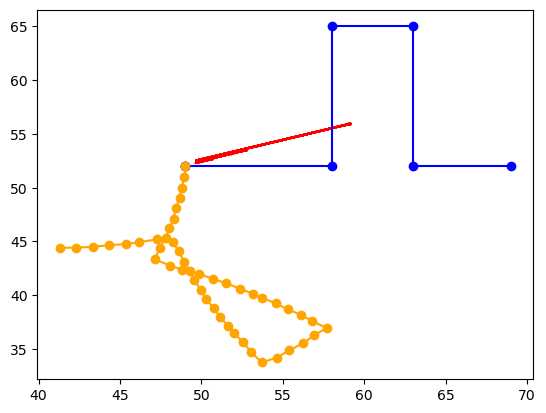

# of particle: 3000
move_particles 실행 시간: 0.00109초
calculate_weights 실행 시간: 0.45900초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00024초
run_filter 실행 시간: 0.49811초
[(49, 52), (50.63760816931652, 52.53048030400428)]


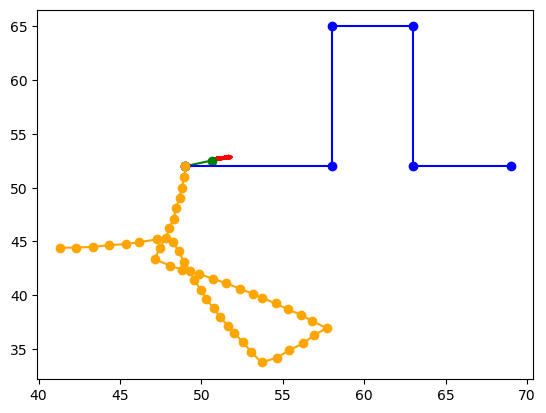

# of particle: 3000
move_particles 실행 시간: 0.00144초
calculate_weights 실행 시간: 0.74235초
resample_particles 실행 시간: 0.00109초
estimate_position 실행 시간: 0.00007초
run_filter 실행 시간: 0.78464초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942)]


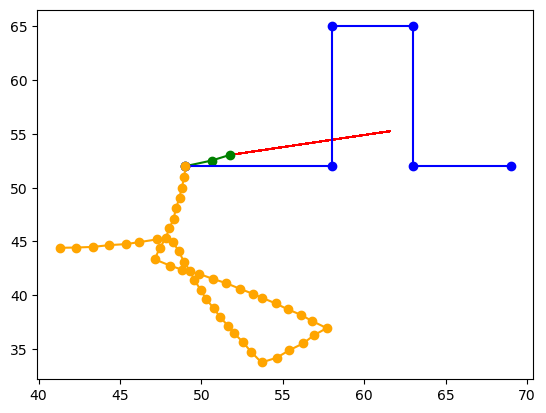

# of particle: 3000
move_particles 실행 시간: 0.00180초
calculate_weights 실행 시간: 0.10851초
resample_particles 실행 시간: 0.00013초
estimate_position 실행 시간: 0.00008초
run_filter 실행 시간: 0.19785초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564)]


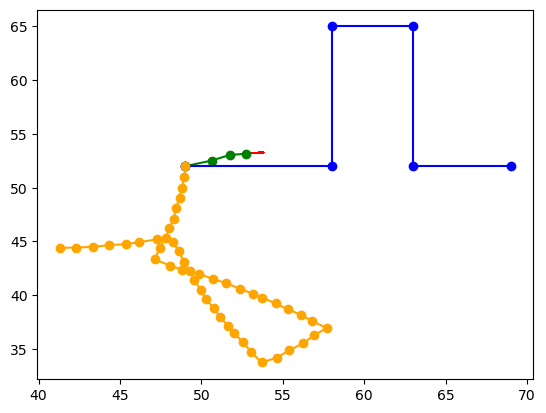

# of particle: 3000
move_particles 실행 시간: 0.00102초
calculate_weights 실행 시간: 0.11310초
resample_particles 실행 시간: 0.00019초
estimate_position 실행 시간: 0.00010초
run_filter 실행 시간: 0.15635초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892)]


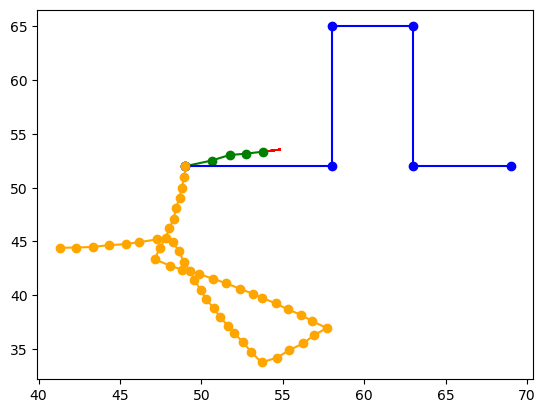

# of particle: 3000
move_particles 실행 시간: 0.00141초
calculate_weights 실행 시간: 0.10777초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00064초
run_filter 실행 시간: 0.15002초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645)]


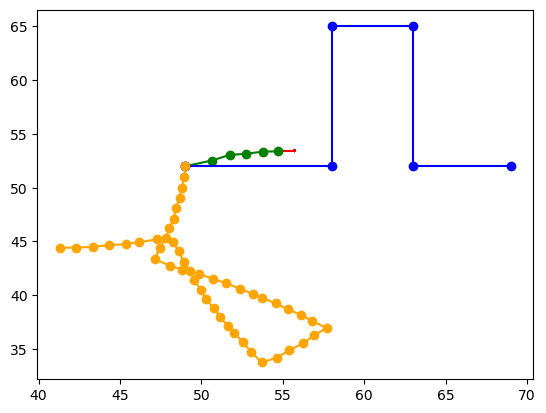

# of particle: 3000
move_particles 실행 시간: 0.00163초
calculate_weights 실행 시간: 0.36584초
resample_particles 실행 시간: 0.00144초
estimate_position 실행 시간: 0.00856초
run_filter 실행 시간: 0.44622초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485)]


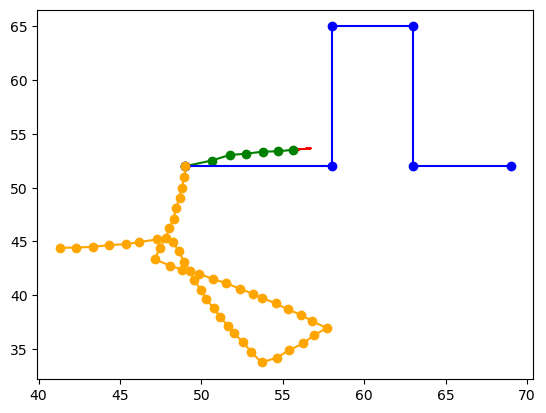

# of particle: 3000
move_particles 실행 시간: 0.00142초
calculate_weights 실행 시간: 0.11117초
resample_particles 실행 시간: 0.00025초
estimate_position 실행 시간: 0.00069초
run_filter 실행 시간: 0.16041초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295)]


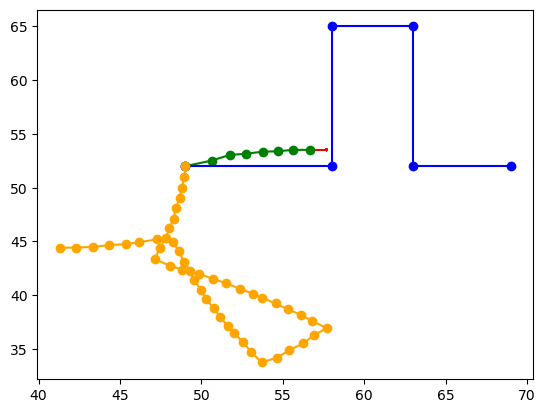

# of particle: 3000
move_particles 실행 시간: 0.00140초
calculate_weights 실행 시간: 0.10628초
resample_particles 실행 시간: 0.00013초
estimate_position 실행 시간: 0.00063초
run_filter 실행 시간: 0.15339초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547)]


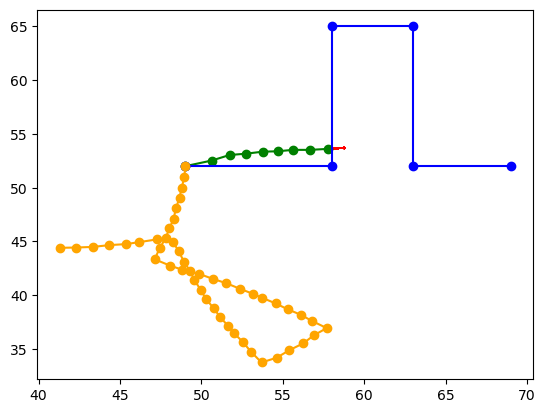

# of particle: 3000
move_particles 실행 시간: 0.00168초
calculate_weights 실행 시간: 0.41003초
resample_particles 실행 시간: 0.00023초
estimate_position 실행 시간: 0.00090초
run_filter 실행 시간: 0.45146초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205)]


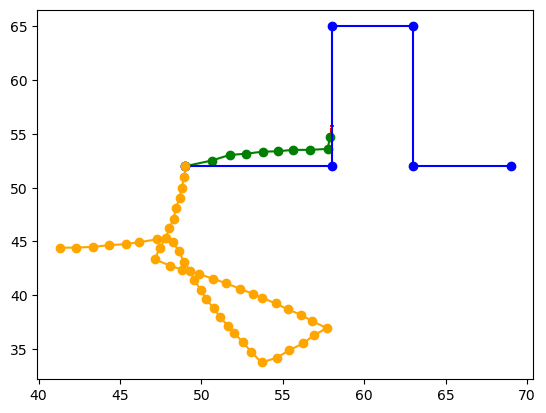

# of particle: 3000
move_particles 실행 시간: 0.00191초
calculate_weights 실행 시간: 0.10697초
resample_particles 실행 시간: 0.00013초
estimate_position 실행 시간: 0.00063초
run_filter 실행 시간: 0.15449초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146)]


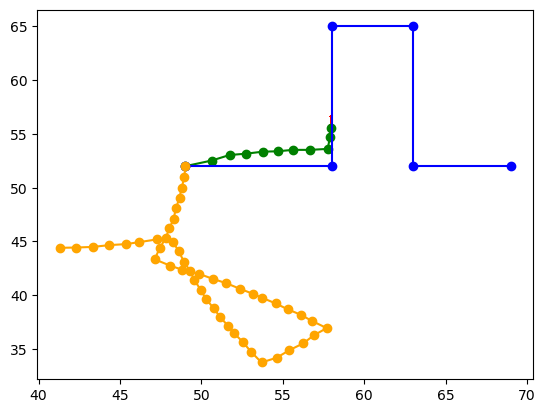

# of particle: 3000
move_particles 실행 시간: 0.00199초
calculate_weights 실행 시간: 0.15736초
resample_particles 실행 시간: 0.00023초
estimate_position 실행 시간: 0.00085초
run_filter 실행 시간: 0.20657초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164)]


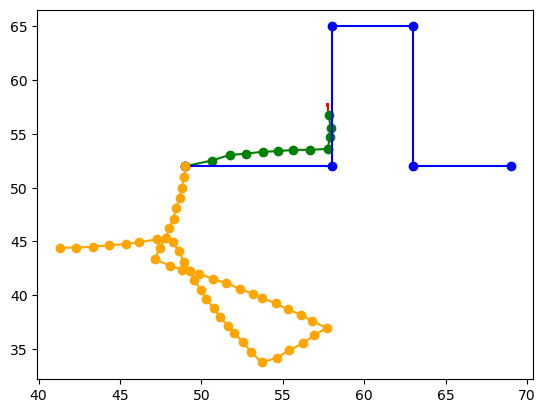

# of particle: 3000
move_particles 실행 시간: 0.00125초
calculate_weights 실행 시간: 0.10663초
resample_particles 실행 시간: 0.00013초
estimate_position 실행 시간: 0.00063초
run_filter 실행 시간: 0.15443초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119)]


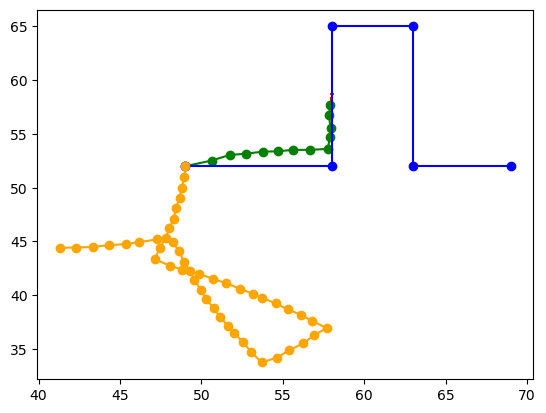

# of particle: 3000
move_particles 실행 시간: 0.00164초
calculate_weights 실행 시간: 0.42606초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00080초
run_filter 실행 시간: 0.46687초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565)]


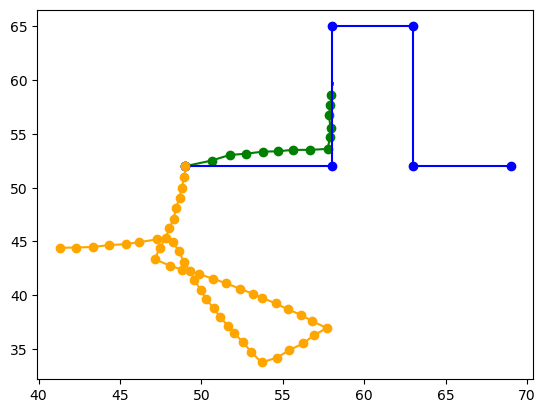

# of particle: 3000
move_particles 실행 시간: 0.00172초
calculate_weights 실행 시간: 0.43966초
resample_particles 실행 시간: 0.00023초
estimate_position 실행 시간: 0.00133초
run_filter 실행 시간: 0.48348초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268)]


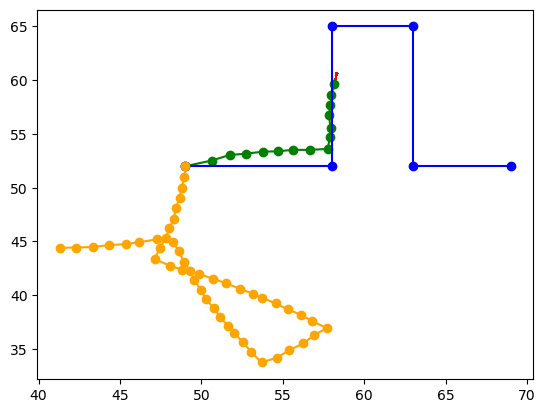

# of particle: 3000
move_particles 실행 시간: 0.00161초
calculate_weights 실행 시간: 0.39086초
resample_particles 실행 시간: 0.00016초
estimate_position 실행 시간: 0.00079초
run_filter 실행 시간: 0.43333초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494)]


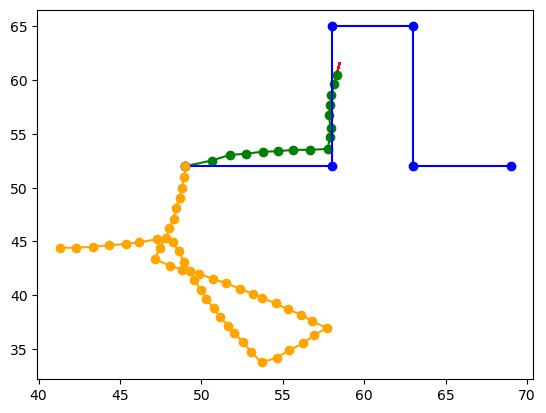

# of particle: 3000
move_particles 실행 시간: 0.00188초
calculate_weights 실행 시간: 0.63085초
resample_particles 실행 시간: 0.00016초
estimate_position 실행 시간: 0.00085초
run_filter 실행 시간: 0.67340초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374)]


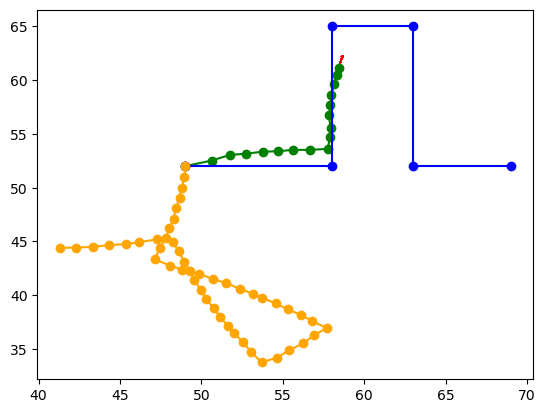

# of particle: 3000
move_particles 실행 시간: 0.00206초
calculate_weights 실행 시간: 0.40322초
resample_particles 실행 시간: 0.00017초
estimate_position 실행 시간: 0.00078초
run_filter 실행 시간: 0.44546초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505)]


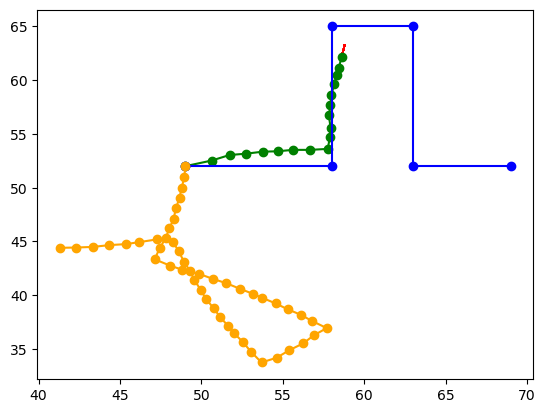

# of particle: 3000
move_particles 실행 시간: 0.00117초
calculate_weights 실행 시간: 0.40395초
resample_particles 실행 시간: 0.00016초
estimate_position 실행 시간: 0.00077초
run_filter 실행 시간: 0.44373초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187)]


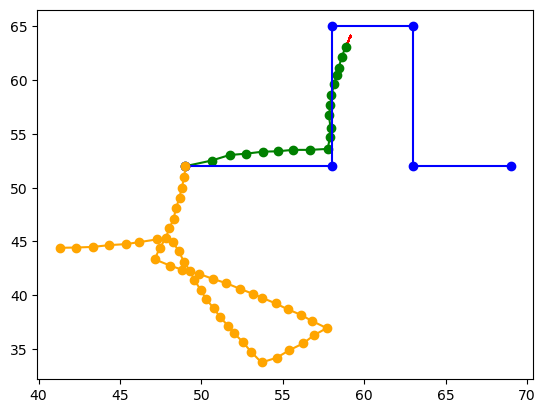

# of particle: 3000
move_particles 실행 시간: 0.00161초
calculate_weights 실행 시간: 0.42339초
resample_particles 실행 시간: 0.00020초
estimate_position 실행 시간: 0.00088초
run_filter 실행 시간: 0.46397초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575)]


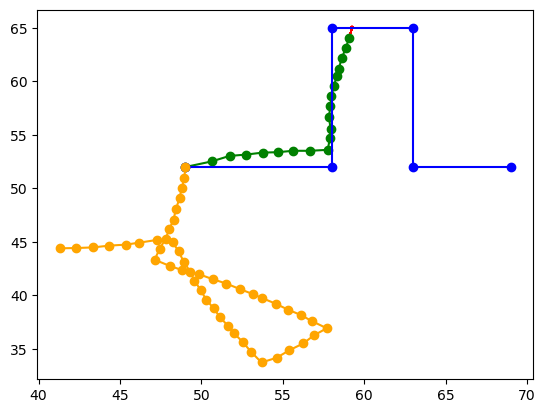

# of particle: 3000
move_particles 실행 시간: 0.00158초
calculate_weights 실행 시간: 0.62789초
resample_particles 실행 시간: 0.00016초
estimate_position 실행 시간: 0.00078초
run_filter 실행 시간: 0.66914초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452)]


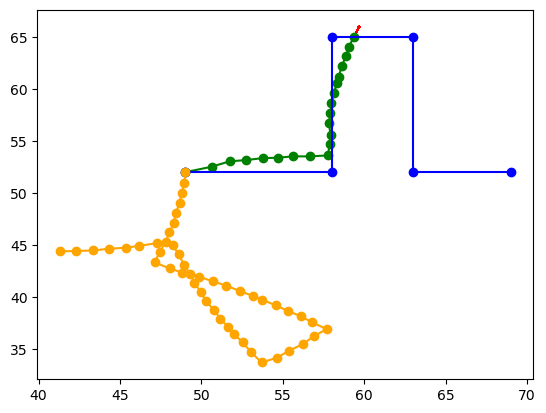

# of particle: 3000
move_particles 실행 시간: 0.00154초
calculate_weights 실행 시간: 0.10727초
resample_particles 실행 시간: 0.00018초
estimate_position 실행 시간: 0.00137초
run_filter 실행 시간: 0.20378초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

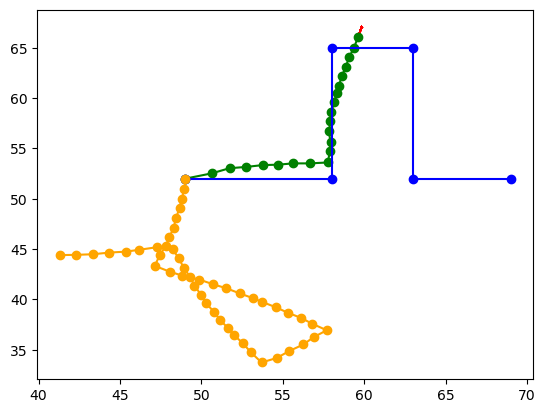

# of particle: 3000
move_particles 실행 시간: 0.00130초
calculate_weights 실행 시간: 0.10688초
resample_particles 실행 시간: 0.00016초
estimate_position 실행 시간: 0.00069초
run_filter 실행 시간: 0.15344초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

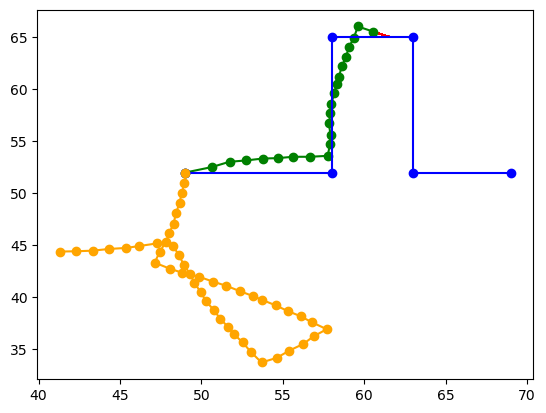

# of particle: 3000
move_particles 실행 시간: 0.00137초
calculate_weights 실행 시간: 0.68490초
resample_particles 실행 시간: 0.00017초
estimate_position 실행 시간: 0.00079초
run_filter 실행 시간: 0.72689초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

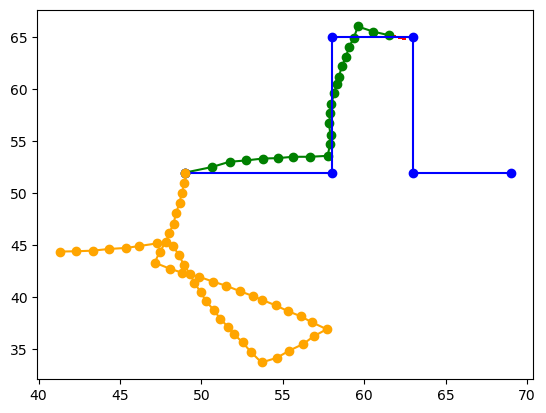

# of particle: 3000
move_particles 실행 시간: 0.00129초
calculate_weights 실행 시간: 0.43763초
resample_particles 실행 시간: 0.00019초
estimate_position 실행 시간: 0.00073초
run_filter 실행 시간: 0.48135초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

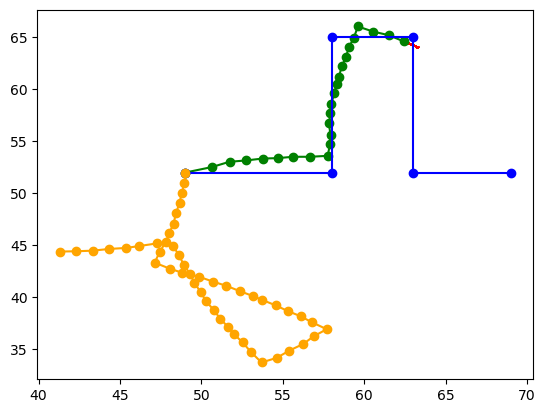

# of particle: 3000
move_particles 실행 시간: 0.00149초
calculate_weights 실행 시간: 0.41674초
resample_particles 실행 시간: 0.00016초
estimate_position 실행 시간: 0.00089초
run_filter 실행 시간: 0.45707초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

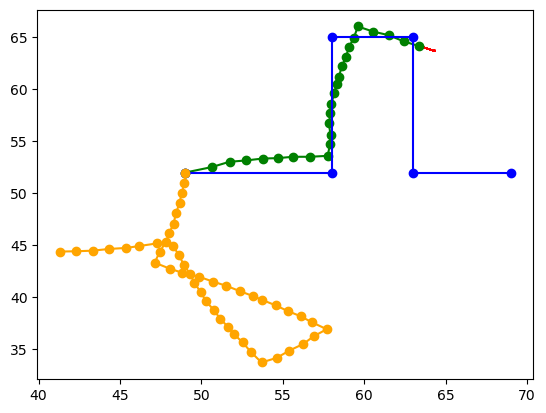

# of particle: 3000
move_particles 실행 시간: 0.00122초
calculate_weights 실행 시간: 0.10821초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00064초
run_filter 실행 시간: 0.20555초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

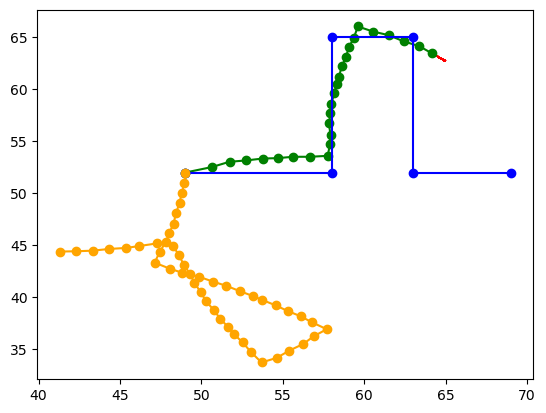

# of particle: 3000
move_particles 실행 시간: 0.00131초
calculate_weights 실행 시간: 0.66642초
resample_particles 실행 시간: 0.00017초
estimate_position 실행 시간: 0.00081초
run_filter 실행 시간: 0.70811초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

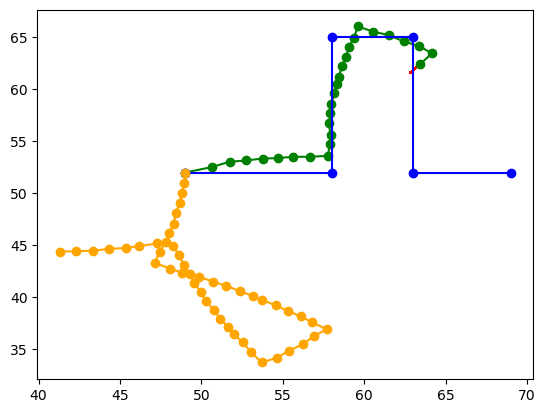

# of particle: 3000
move_particles 실행 시간: 0.00133초
calculate_weights 실행 시간: 0.39383초
resample_particles 실행 시간: 0.00022초
estimate_position 실행 시간: 0.00110초
run_filter 실행 시간: 0.43599초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

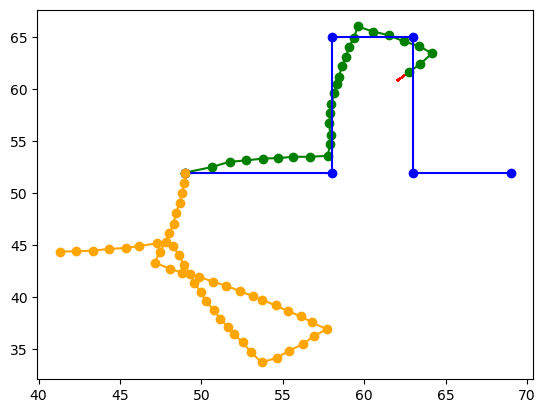

# of particle: 3000
move_particles 실행 시간: 0.00157초
calculate_weights 실행 시간: 0.42357초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00080초
run_filter 실행 시간: 0.46551초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

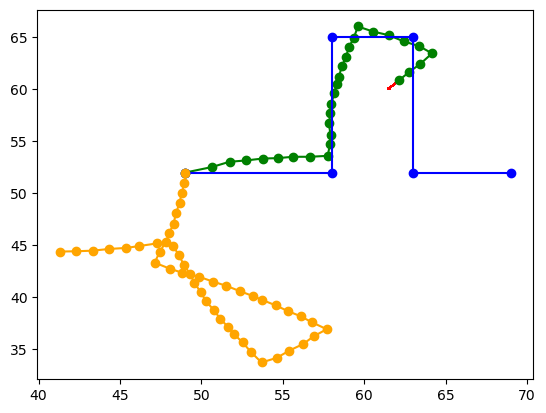

# of particle: 3000
move_particles 실행 시간: 0.00168초
calculate_weights 실행 시간: 0.63543초
resample_particles 실행 시간: 0.00021초
estimate_position 실행 시간: 0.00086초
run_filter 실행 시간: 0.67826초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

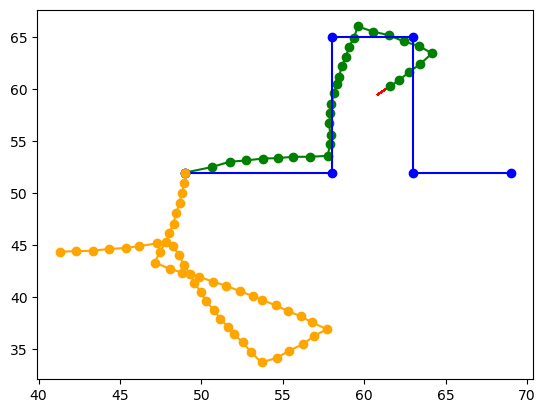

# of particle: 3000
move_particles 실행 시간: 0.00202초
calculate_weights 실행 시간: 0.41191초
resample_particles 실행 시간: 0.00624초
estimate_position 실행 시간: 0.00248초
run_filter 실행 시간: 0.46791초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

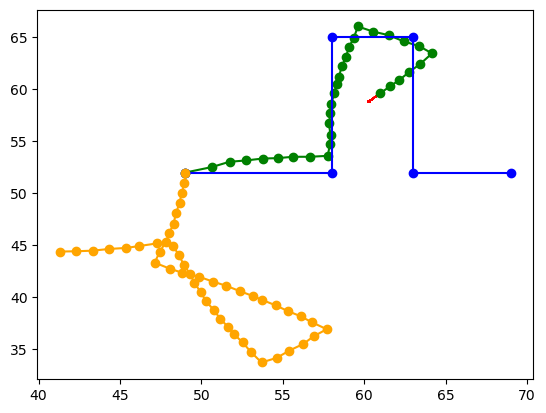

# of particle: 3000
move_particles 실행 시간: 0.00103초
calculate_weights 실행 시간: 0.39047초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00082초
run_filter 실행 시간: 0.43277초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

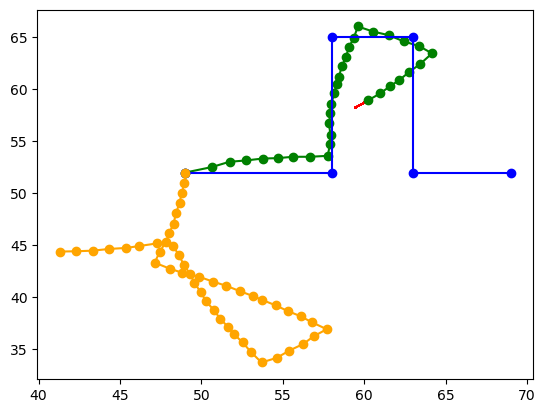

# of particle: 3000
move_particles 실행 시간: 0.00139초
calculate_weights 실행 시간: 0.43068초
resample_particles 실행 시간: 0.00027초
estimate_position 실행 시간: 0.00093초
run_filter 실행 시간: 0.47285초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

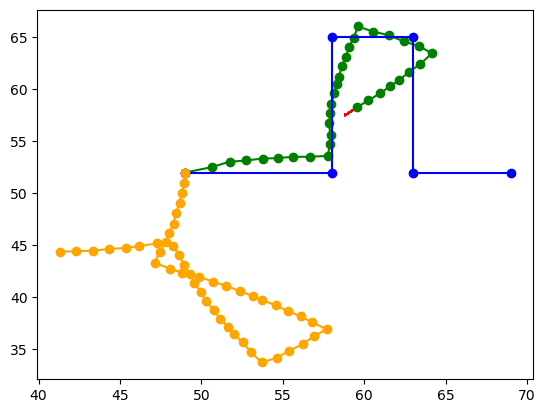

# of particle: 3000
move_particles 실행 시간: 0.00129초
calculate_weights 실행 시간: 0.41471초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00128초
run_filter 실행 시간: 0.45924초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

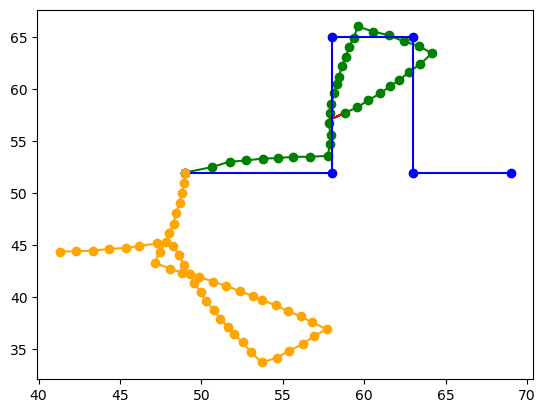

# of particle: 3000
move_particles 실행 시간: 0.00158초
calculate_weights 실행 시간: 0.10514초
resample_particles 실행 시간: 0.00013초
estimate_position 실행 시간: 0.00063초
run_filter 실행 시간: 0.15220초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

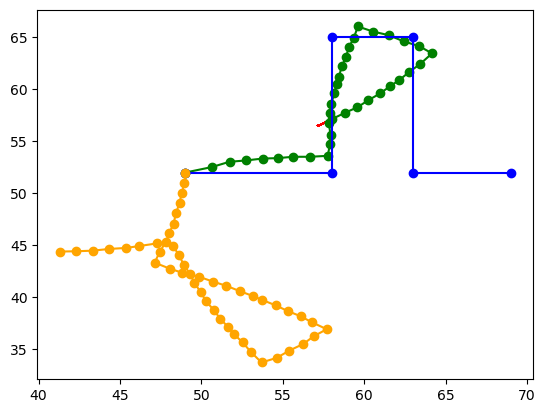

# of particle: 3000
move_particles 실행 시간: 0.00126초
calculate_weights 실행 시간: 0.15192초
resample_particles 실행 시간: 0.00079초
estimate_position 실행 시간: 0.00130초
run_filter 실행 시간: 0.19908초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

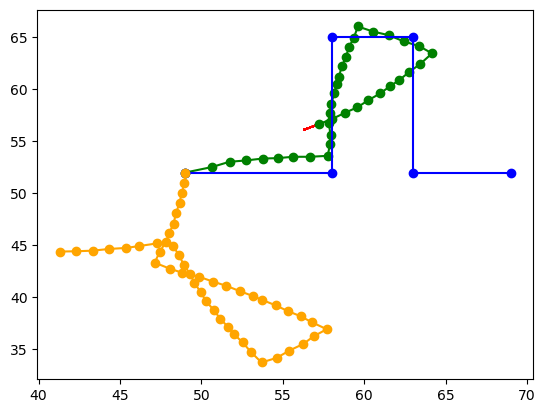

# of particle: 3000
move_particles 실행 시간: 0.00107초
calculate_weights 실행 시간: 0.37029초
resample_particles 실행 시간: 0.00017초
estimate_position 실행 시간: 0.00114초
run_filter 실행 시간: 0.41207초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

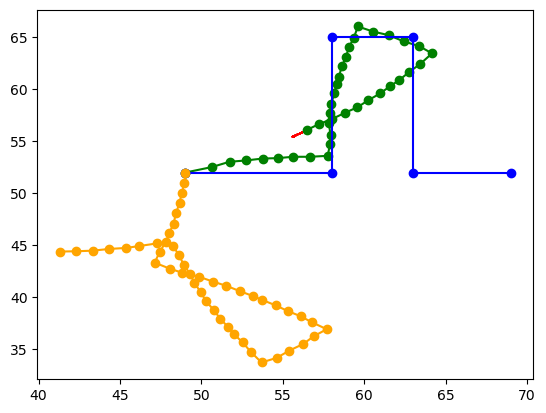

# of particle: 3000
move_particles 실행 시간: 0.00244초
calculate_weights 실행 시간: 0.10570초
resample_particles 실행 시간: 0.00013초
estimate_position 실행 시간: 0.00062초
run_filter 실행 시간: 0.19691초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

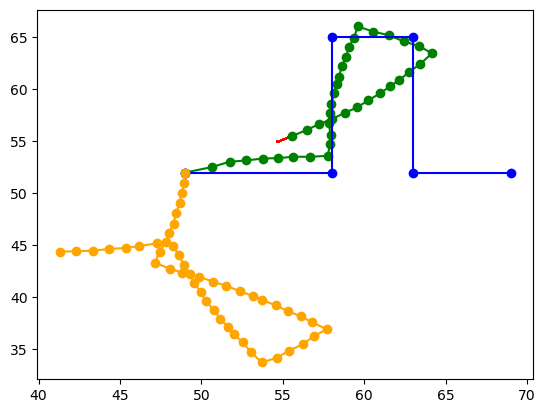

# of particle: 3000
move_particles 실행 시간: 0.00099초
calculate_weights 실행 시간: 0.11217초
resample_particles 실행 시간: 0.00019초
estimate_position 실행 시간: 0.00069초
run_filter 실행 시간: 0.15658초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

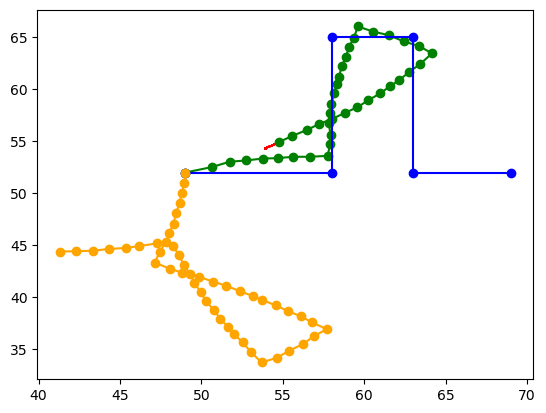

# of particle: 3000
move_particles 실행 시간: 0.00099초
calculate_weights 실행 시간: 0.36282초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00075초
run_filter 실행 시간: 0.45041초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

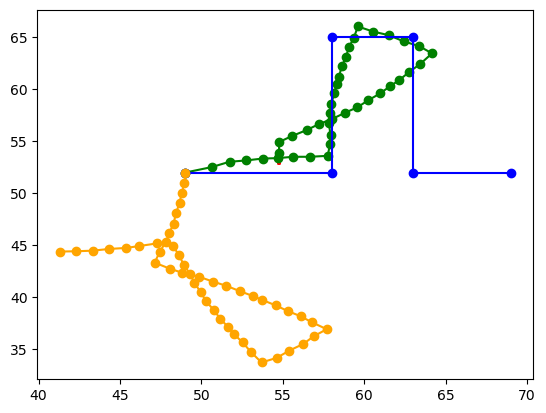

# of particle: 3000
move_particles 실행 시간: 0.00206초
calculate_weights 실행 시간: 0.39538초
resample_particles 실행 시간: 0.00015초
estimate_position 실행 시간: 0.00077초
run_filter 실행 시간: 0.43607초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

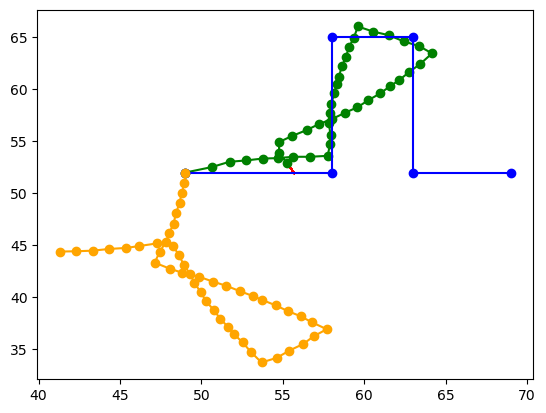

# of particle: 3000
move_particles 실행 시간: 0.00126초
calculate_weights 실행 시간: 0.43411초
resample_particles 실행 시간: 0.00016초
estimate_position 실행 시간: 0.00078초
run_filter 실행 시간: 0.47362초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

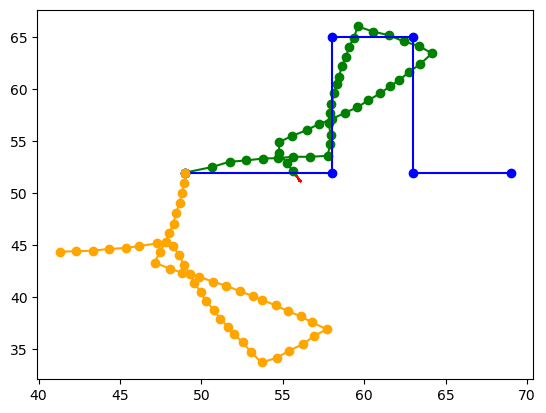

# of particle: 3000
move_particles 실행 시간: 0.00152초
calculate_weights 실행 시간: 0.38710초
resample_particles 실행 시간: 0.00014초
estimate_position 실행 시간: 0.00080초
run_filter 실행 시간: 0.43044초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

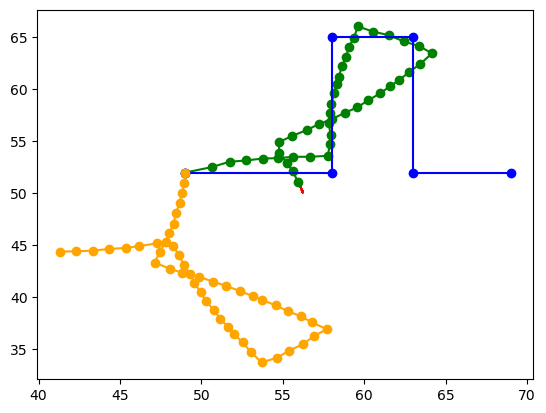

# of particle: 3000
move_particles 실행 시간: 0.00132초
calculate_weights 실행 시간: 0.65884초
resample_particles 실행 시간: 0.00022초
estimate_position 실행 시간: 0.00143초
run_filter 실행 시간: 0.70073초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

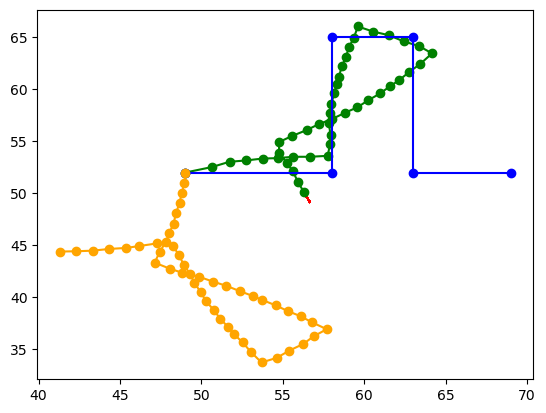

# of particle: 3000
move_particles 실행 시간: 0.00141초
calculate_weights 실행 시간: 0.39334초
resample_particles 실행 시간: 0.00018초
estimate_position 실행 시간: 0.00074초
run_filter 실행 시간: 0.43862초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

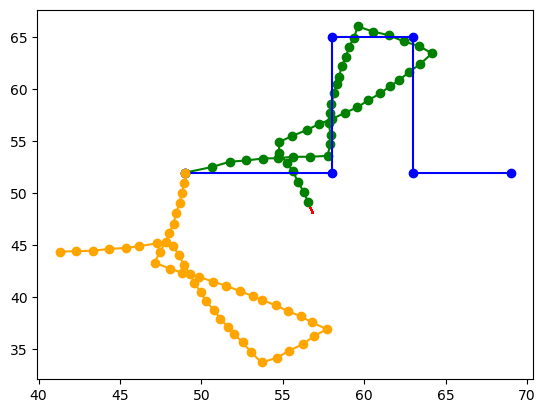

# of particle: 3000
move_particles 실행 시간: 0.00108초
calculate_weights 실행 시간: 0.39368초
resample_particles 실행 시간: 0.00016초
estimate_position 실행 시간: 0.00077초
run_filter 실행 시간: 0.47572초
[(49, 52), (50.63760816931652, 52.53048030400428), (51.72579850903753, 53.04141471621942), (52.735683704533386, 53.16596625273564), (53.76029740479502, 53.35144820200892), (54.67906920488042, 53.38948291641645), (55.6261600000357, 53.520723055863485), (56.64933722189743, 53.51985146337295), (57.751240076546225, 53.61057062543547), (57.89390861605477, 54.71975672906205), (57.926263199066845, 55.601623130764146), (57.82569619200868, 56.72151079330164), (57.92385097486731, 57.69319718639119), (57.98018739941327, 58.631725967702565), (58.14549532892693, 59.60800817961268), (58.304509473029725, 60.525113329029494), (58.43766515270654, 61.18003967103374), (58.61343466000136, 62.20524370933505), (58.86893106119339, 63.11128991402187), (59.05569640395307, 64.05743859414575), (59.351037779399356, 64.94265378687452), 

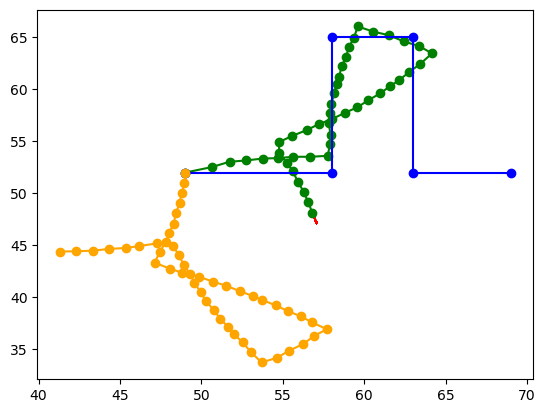

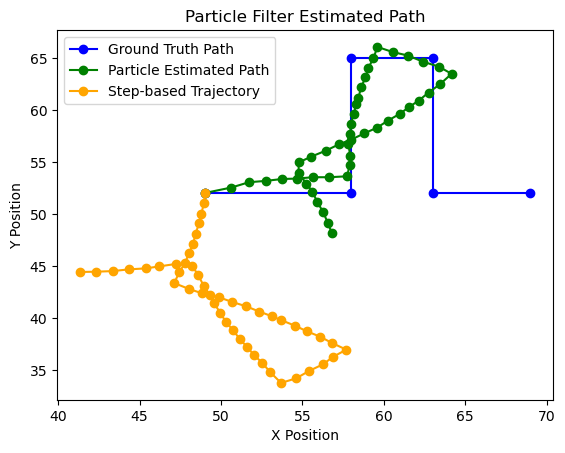

In [290]:
from step_length import *
from step_orientation import *

acc_df = pd.read_csv("../data/Path4_freeOri_A31/Accelerometer.csv")
gyro_df = pd.read_csv("../data/Path4_freeOri_A31/GyroscopeUncalibrated.csv")
mag_df = pd.read_csv("../data/Path4_freeOri_A31/MagnetometerUncalibrated.csv")
mag_df['mag'] = mag_df.apply(lambda x: math.sqrt(x['x']*x['x'] + x['y']*x['y'] + x['z']*x['z']), axis=1 )
del mag_df['x']
del mag_df['y']
del mag_df['z']

path_1 = pd.DataFrame([(92, 47), (102, 47), (102, 40), (92,40), (92,47)], columns=['x', 'y'])
path_2 = pd.DataFrame([(114, 25), (118, 25), (118, 13), (114,13), (114, 25)], columns=['x', 'y'])
path_3 = pd.DataFrame([(33, 28), (38, 28), (44, 22)], columns=['x', 'y'])
path_4 = pd.DataFrame([(49, 52), (58, 52), (58, 65), (63, 65), (63, 52), (69, 52)], columns=['x', 'y'])

step_lengths = compute_step_timestamp(
    acceleration_threshold=0.001,
    weinberg_gain=0.5,
    acce=acc_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
    frequency=100.0
)
step_orientation_radians: list[float] = []

# Plot Ground Truth Path
ground_truth_path = path_4

# Tranjectory
x, y = ground_truth_path.iloc[0]  # 초기 위치
trajectory_x = [x]
trajectory_y = [y]
current_angle = 0  # 초기 방향 (radians)

for step in step_lengths:
    step_length = step['step_length']
    start = step['start']
    end = step['end']

    # Turning estimation
    estimated_radian = estimate_turning_angle(
        gyro_data=gyro_df.iloc[start:end, :],
        frequency=100.0
    )
    step_orientation_radians.append(estimated_radian)

    # 방향 업데이트
    current_angle += estimated_radian  
    
    step_length /= 0.6
    # 새로운 위치 계산
    dx = step_length * math.cos(current_angle)
    dy = step_length * math.sin(current_angle)
    x += dx
    y += dy
    trajectory_x.append(x)
    trajectory_y.append(y)

print(f"assert that len(step_length): {len(step_lengths)} = len(step_orientation_radians): {len(step_orientation_radians)}")

estimated_positions = []

for idx, (step_length, step_orientation_radian) in enumerate(zip(step_lengths, step_orientation_radians)):
    length = step_length['step_length']
    start = step_length['start']
    end = step_length['end']
    
    use_weighted_average = True
    if 0 <= idx < 5:
        use_weighted_average = False

    result = pf.run_filter(mag_df.iloc[start:end], length, step_orientation_radian, idx == 0, use_weighted_average)
    estimated_positions += result
    
    print(estimated_positions)
    # NumPy 배열로 변환
    positions_array = np.array(estimated_positions)
    
    # 첫 번째 점
    if idx == 0:
        plt.plot(positions_array[0, 0], positions_array[0, 1], marker='o', color='green', label="Particle Estimated Path")
    else:
        # 이전까지의 경로
        plt.plot(positions_array[:idx+1, 0], positions_array[:idx+1, 1], marker='o', color='green', label="Particle Estimated Path")

    plt.plot(ground_truth_path['x'], ground_truth_path['y'], marker='o', color='blue', label='Ground Truth Path')
    plt.plot(trajectory_x, trajectory_y, marker='o', color='orange', label="Step-based Trajectory")
    plt.show()

#Plot results
estimated_positions = np.array(estimated_positions)
estimated_positions = np.squeeze(estimated_positions)  # (n, 2)로 변환

plt.plot(ground_truth_path['x'], ground_truth_path['y'], marker='o', color='blue', label='Ground Truth Path')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], marker='o', color='green', label="Particle Estimated Path")
plt.plot(trajectory_x, trajectory_y, marker='o', color='orange', label="Step-based Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Particle Filter Estimated Path")
plt.show()
